In [1]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml

from model.model import get_model
from data_loader import TrainDataModule, get_all_test_dataloaders, get_normal_test_dataloader, get_train_dataloader
from ganomaly_eval import GanomalyEvaluator, EvalType
from torch.utils.data import Dataset, DataLoader


# autoreload imported modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

Global seed set to 42


Loading model ganomaly
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


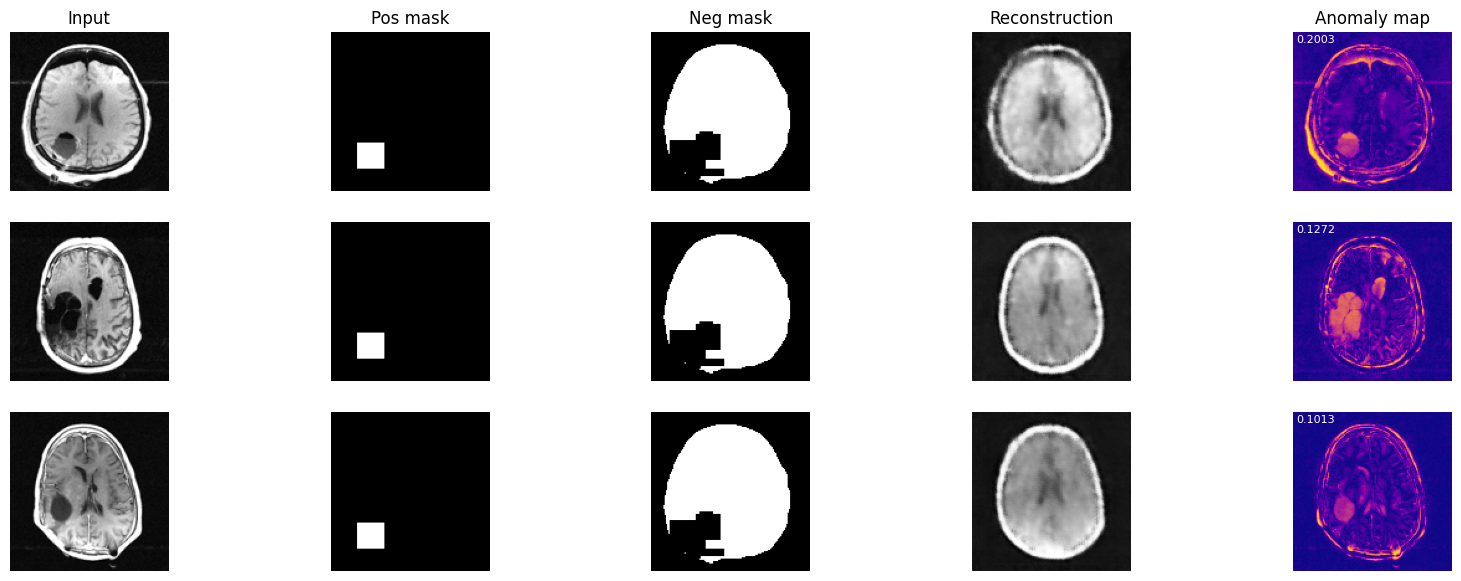

In [25]:
# with open("./configs/ganomaly_config.yaml", "r") as f:
best = (
    "/home/marcel/Projects/uni/mad_seminar/models/dulcet-music-21/ganomaly_config.yaml"
)
test = "./configs/ganomaly_config.yaml"
with open(best, "r") as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config["seed"])

# load model from checkpit
from data_loader import PosterDataset
from model.ganomaly.lightning_model import Ganomaly
import numpy as np


model = get_model(config)

# model = Ganomaly(
#     batch_size=256,
#     input_size=(64, 64),
#     latent_vec_size=256,  # 256,
#     wadv=1,
#     wcon=50,
#     wenc=1,
#     # lr=config["lr"],
#     beta1=0.5,
#     beta2=0.999,
# )
# custom_cp = "/home/marcel/Projects/uni/mad_seminar/lightning_logs/version_1/checkpoints/epoch=149-step=300.ckpt"
# Initialize the model by loading from the checkpoint
best_cp = "models/dulcet-music-21/epoch=149-step=2400.ckpt"
model.load_state_dict(torch.load(best_cp)["state_dict"])
# model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

# normal_test = "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000347.png"

# file_keys = ["file_brain_AXT1_202_6000518.png", "file_brain_AXT1_202_6000518.png"]
# img_base_path = "/home/marcel/Projects/uni/mad_seminar/data/fastMRI/brain_mid_png/"
# pos_base_path = (
#     "/home/marcel/Projects/uni/mad_seminar/data/fastMRI/brain_mid_anno_pos_png/"
# )
# neg_base_path = (
#     "/home/marcel/Projects/uni/mad_seminar/data/fastMRI/brain_mid_anno_neg_png/"
# )
img = ["./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000518.png",
       "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020009.png",
       "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_2020156.png",
       "./data/fastMRI/brain_mid_png/file_brain_AXT1_202_6000465.png"]
pos = [
    "/home/marcel/Projects/uni/mad_seminar/data/fastMRI/brain_mid_anno_pos_png/file_brain_AXT1_202_6000518_craniotomy_1.png"
] * len(img)
neg = [
    "/home/marcel/Projects/uni/mad_seminar/data/fastMRI/brain_mid_anno_neg_png/file_brain_AXT1_202_6000518.png"
] * len(img)

poster_dl = DataLoader(
    PosterDataset(
        target_size=(128, 128),
        # img_paths=[img_base_path + f for f in file_keys],
        # pos_mask_paths=[pos_base_path + f for f in file_keys],
        # neg_mask_paths=[neg_base_path + f for f in file_keys],
        img_paths=img,
        pos_mask_paths=pos,
        neg_mask_paths=neg,
    ),
    batch_size=1,
)

data = []

for batch in poster_dl:
    img, pos_mask, neg_mask = batch
    print(img.shape)
    out = model.detect_anomaly(img)  # dict of rec, anoamly maps, anomaly score
    out["img"] = img
    out["pos_mask"] = pos_mask
    out["neg_mask"] = neg_mask
    out["anomaly_map"] = np.abs(img - out["reconstruction"])
    data.append(out)

fig, ax = plt.subplots(len(data), 5, figsize=(20, 7))

for i, d in enumerate(data):
    if i == 0:
        ax[i, 0].set_title("Input")
        ax[i, 1].set_title("Pos mask")
        ax[i, 2].set_title("Neg mask")
        ax[i, 3].set_title("Reconstruction")
        ax[i, 4].set_title("Anomaly map")
    ax[i, 0].imshow(d["img"].squeeze(), cmap="gray")
    ax[i, 1].imshow(d["pos_mask"].squeeze(), cmap="gray")
    ax[i, 2].imshow(d["neg_mask"].squeeze(), cmap="gray")
    ax[i, 3].imshow(d["reconstruction"].squeeze(), cmap="gray")
    ax[i, 4].imshow(d["anomaly_map"].squeeze(), cmap="plasma")
    ax[i, 4].text(2, 8, f"{d['anomaly_score'].item():.4f}", color='white', fontsize=8)

    for ax_ in ax[i]:
        ax_.axis("off")
plt.show()